In [363]:
from collections import defaultdict
import copy
import itertools as it
import json
import os
import pickle
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import collections as mc
import networkx as nximport
import numpy as np
from scipy import stats
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel
from rlpyt.utils.seed import make_seed, get_seed

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

In [11]:
for _ in range(4):
    print(make_seed())

7712
233
8921
9835


In [265]:
def plot_topdown(env, fig, linewidth=2):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=linewidth)

def get_s_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

## Visualization: local policy success rate over time

In [594]:
eval_dir = '../data/local/20201001/vizdoom/run_9/'
eval_dir = '../data/visualize/run_8'

In [595]:
config = json.load(open(os.path.join(eval_dir, 'params.json')))
config['env']['config'] = '../' + config['env']['config']
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [596]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [259]:
env = VizDoomEnv(**config['env'])

In [121]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

KeyboardInterrupt: 

In [183]:
itr = 20000 - 1

In [185]:
top_attempted_landmarks = np.argpartition(np.sum(subgoal_attempts, axis=0), -50)[-50:]
x, y = np.meshgrid(top_attempted_landmarks, top_attempted_landmarks)

In [186]:
original_landmarks = np.zeros((N, N), dtype=bool)
original_landmarks[x, y] = True

### Visualizing Subgoal Policy Success Rate

In [597]:
def get_subgoal_data(itr, success_rate_threshold, attempts_threshold):
    itr -= 1
    landmarks = np.load(os.path.join(eval_dir, 'landmarks_itr_{}.npz'.format(itr)))

    positions = landmarks['positions']
    N = len(positions)

    edge_subgoal_steps = landmarks['edge_subgoal_steps']
    edge_subgoal_failures = landmarks['edge_subgoal_failures']
    edge_subgoal_successes = landmarks['edge_subgoal_successes']
    edge_subgoal_attempts = landmarks['edge_subgoal_attempts']
    subgoal_successes = edge_subgoal_successes + np.tril(edge_subgoal_successes, -1).T + np.triu(edge_subgoal_successes, 1).T
    subgoal_attempts = edge_subgoal_attempts + np.tril(edge_subgoal_attempts, -1).T + np.triu(edge_subgoal_attempts, 1).T

    subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T + np.triu(edge_subgoal_steps, 1).T
    subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T + np.triu(edge_subgoal_failures, 1).T

    average_subgoal_steps = subgoal_steps / np.clip(subgoal_successes, 1, None)

    print('Number of landmarks:', N)

    failure_edges = np.argwhere(subgoal_failures > 0)
    print('Number of failure edges:', failure_edges.shape[0])
    subgoal_success_edges = np.argwhere(subgoal_successes > 0)
    print('Number of subgoal edges:', subgoal_success_edges.shape[0])
    subgoal_attempt_edges = np.argwhere(subgoal_attempts > 0)
    print('Number of attempt edges:', subgoal_attempt_edges.shape[0])
    
    subgoal_success_rate = subgoal_successes / np.clip(subgoal_attempts, 1, None)
    
    subgoal_edges = np.argwhere((subgoal_success_rate > success_rate_threshold) & (subgoal_attempts > attempts_threshold))
    failed_subgoal_edges = np.argwhere((subgoal_success_rate > 0) & (subgoal_success_rate <= success_rate_threshold) \
                                       & (subgoal_attempts > attempts_threshold))
    
    subgoal_edge_rate = subgoal_success_rate[subgoal_edges[:, 0], subgoal_edges[:, 1]]
    
    return positions, subgoal_edges, failed_subgoal_edges, subgoal_edge_rate

Number of landmarks: 282
Number of failure edges: 0
Number of subgoal edges: 134
Number of attempt edges: 162
Number of landmarks: 481
Number of failure edges: 0
Number of subgoal edges: 594
Number of attempt edges: 686


<Figure size 432x288 with 0 Axes>

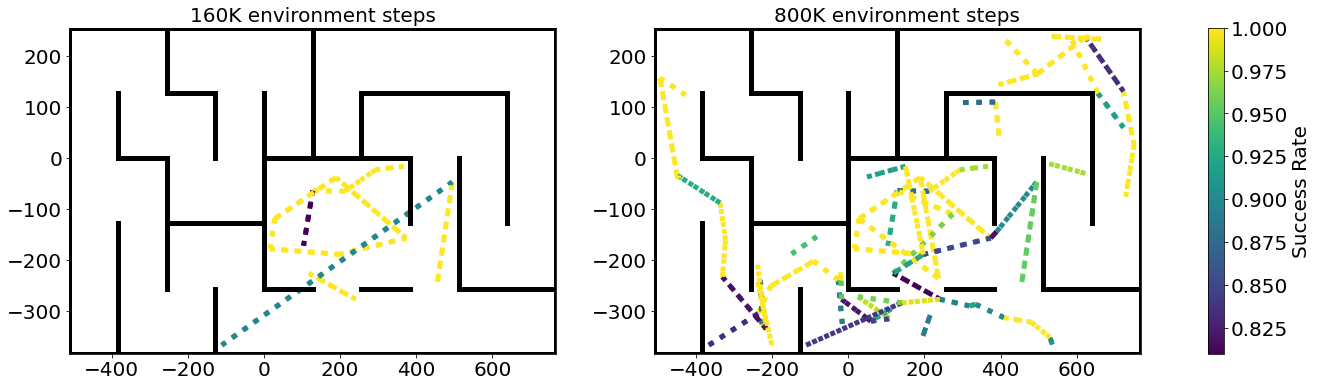

In [617]:
plt.set_cmap('viridis')
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

for i, itr in enumerate([20000, 100000]):
    positions, subgoal_edges, failed_subgoal_edges, subgoal_edge_rate = get_subgoal_data(itr, 0.80, 5)
    starts = positions[subgoal_edges[:, 0], :2]
    ends = positions[subgoal_edges[:, 1], :2]
    lc = mc.LineCollection(list(zip(starts, ends)),
                           linewidths=5, linestyle='dotted')
    lc.set_array(subgoal_edge_rate)
    ax[i].add_collection(lc)
    ax[i].tick_params(labelsize=20)

    ax[i].set_xlim(env.min_x, env.max_x)
    ax[i].set_ylim(env.min_y, env.max_y)
    plot_topdown(env, ax[i], linewidth=5)
    ax[i].set_title('{:.0f}K environment steps'.format(itr * 8 / 1000), fontsize=20)
    
cbar = plt.colorbar(lc, ax=ax.ravel().tolist())
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('Success Rate', fontsize=20)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/local-policy-success-rate.png')

In [191]:
# subgoal_edges = np.argwhere((average_subgoal_steps > 0) & (average_subgoal_steps < 20))
# failed_subgoal_edges = np.argwhere((average_subgoal_steps >= 20))

# subgoal_edge_steps = average_subgoal_steps[subgoal_edges[:, 0], subgoal_edges[:, 1]]
# values = np.interp(subgoal_edge_steps, (subgoal_edge_steps.min(), subgoal_edge_steps.max()), (0, 1))
# values = stats.rankdata(subgoal_edge_steps, 'average') / len(subgoal_edge_steps)

In [293]:
def get_path(goal_pair, feature_model, dsr_model, graph):
    start_pos, goal_pos = goal_pair
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state, feature_model, dsr_model)
    goal_sf = get_s_features(goal_state, feature_model, dsr_model)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        path = None
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [262]:
itr = 200000 - 1
landmarks = np.load(os.path.join(eval_dir, 'landmarks_itr_{}.npz'.format(itr)))

positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
if 'edge_subgoal_successes' in landmarks:
    edge_subgoal_successes = landmarks['edge_subgoal_successes']
    edge_subgoal_attempts = landmarks['edge_subgoal_attempts']
    subgoal_successes = edge_subgoal_successes + np.tril(edge_subgoal_successes, -1).T + np.triu(edge_subgoal_successes, 1).T
    subgoal_attempts = edge_subgoal_attempts + np.tril(edge_subgoal_attempts, -1).T + np.triu(edge_subgoal_attempts, 1).T
    
random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T + np.triu(edge_random_transitions, 1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T + np.triu(edge_subgoal_steps, 1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T + np.triu(edge_subgoal_failures, 1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)

if 'edge_subgoal_successes' in landmarks:
    average_subgoal_steps = subgoal_steps / np.clip(subgoal_successes, 1, None)


transitions = random_transitions #  + subgoal_successes

print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)
temporally_nearby_landmarks += temporally_nearby_landmarks.T


failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])
if 'edge_subgoal_successes' in landmarks:
    subgoal_success_edges = np.argwhere(subgoal_successes > 0)
    print('Number of subgoal edges:', subgoal_success_edges.shape[0])
    subgoal_attempt_edges = np.argwhere(subgoal_attempts > 0)
    print('Number of attempt edges:', subgoal_attempt_edges.shape[0])

true_edges = random_transitions >= threshold
true_edges = temporally_nearby_landmarks & true_edges

# k = 5
# nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
# k_filter = np.zeros((N, N), dtype=bool)
# idx = np.vstack([np.arange(N)] * k).T
# k_filter[idx, nearest_neighbors] = True
# true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

print('Number of edges:', np.sum(edge_weights > 0))
edges = np.argwhere(edge_weights > 0)

Number of landmarks: 517
Number of non-zero random transitions: 16256
50 percentile of random transitions: 3.0
Number of failure edges: 714
Number of edges: 3212


In [263]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [266]:
visitations = np.sum(random_transitions, axis=0)
visitations_percentile = stats.rankdata(visitations, 'average') / len(visitations)

<Figure size 432x288 with 0 Axes>

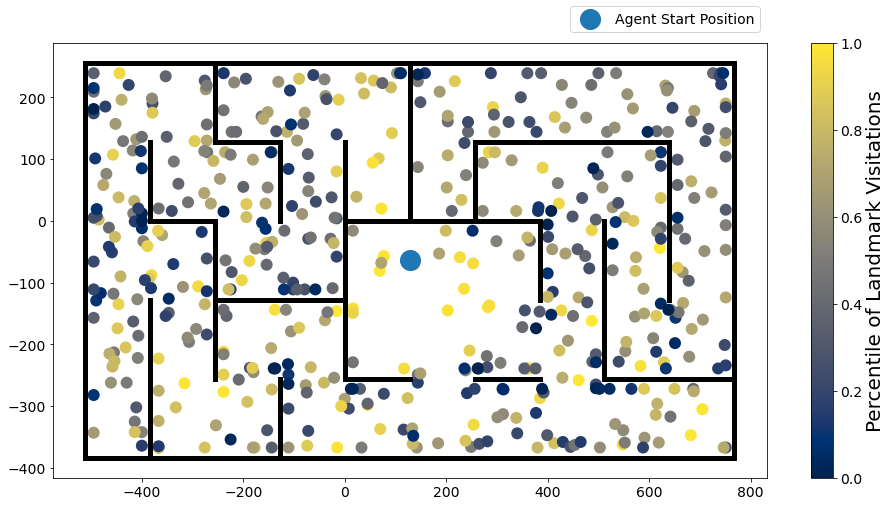

In [290]:
plt.set_cmap('cividis')
fig = plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, 5)

plt.scatter(positions[:, 0], positions[:, 1], c=visitations_percentile, s=144, edgecolor='none')
plt.scatter(*env.start_info[1][:2], s=400, color='tab:blue', label='Agent Start Position')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Percentile of Landmark Visitations', fontsize=20)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-percentile-visitations.png')

<Figure size 432x288 with 0 Axes>

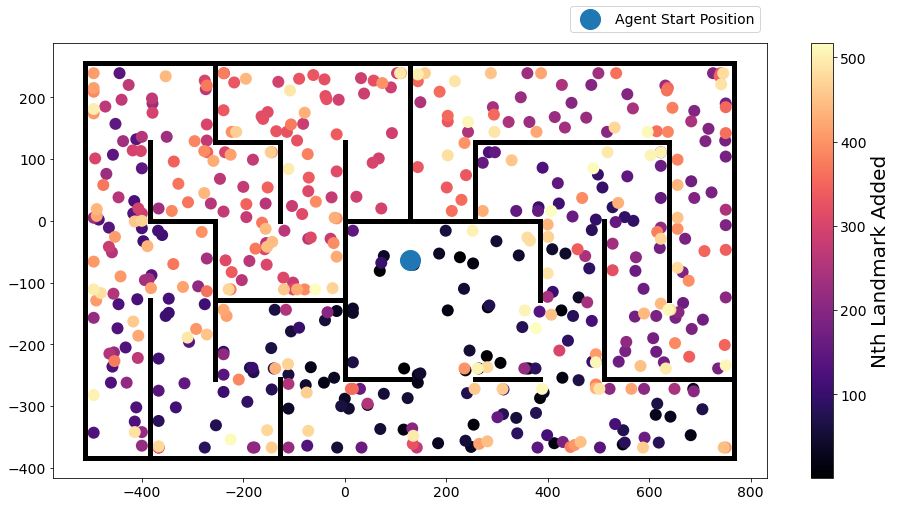

In [286]:
plt.set_cmap('magma')
fig = plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, 5)

plt.scatter(positions[:, 0], positions[:, 1], c=np.arange(N), s=144, edgecolor='none')
plt.scatter(*env.start_info[1][:2], s=400, color='tab:blue', label='Agent Start Position')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))
cbar = plt.colorbar()
plt.clim(1, N)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Nth Landmark Added', fontsize=20)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-landmark-add-order.png')

## Intro Figure

In [294]:
graph = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)

In [295]:
goal_pair = [[128, -64, 0], [535, 85, 270]]  # goal_pairs['hard'][4]
good_start, good_goal, good_path = get_path(goal_pair, feature_model, dsr_model, graph)

SF start: 36
SF goal: 96
Found path: [36, 74, 77, 79, 81, 126, 96]


In [296]:
exploration_path = good_path[:4]
exploration_landmarks = exploration_path + random_transitions[exploration_path].argmax(axis=1).tolist()[:-1]
cross_exploration_landmarks = np.array(list(it.product(exploration_landmarks, exploration_landmarks)))
exploration_edges = np.zeros((N, N), dtype=bool)
exploration_edges[cross_exploration_landmarks[:, 0], cross_exploration_landmarks[:, 1]] = 1
exploration_edges = edge_weights.copy() * exploration_edges
exploration_edges = np.argwhere(exploration_edges > 0)

In [ ]:
# 1. make exploration path to a closer landmark
# 2. make added landmark be one that is existing to the path to the goal
# 3. current path is the testing path
# 4. add neary landmarks

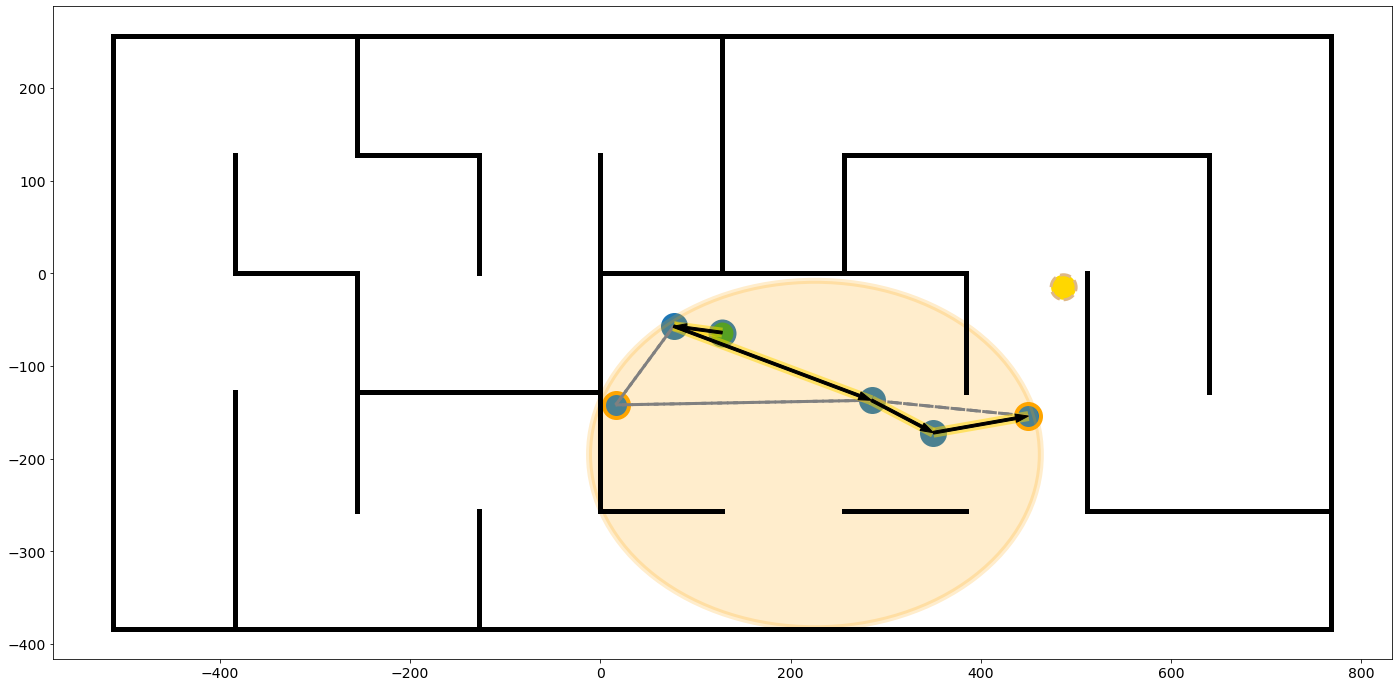

In [310]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=5)
ax = plt.gca()

starts = positions[exploration_edges[:, 0], :2]
ends = positions[exploration_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='gray', linestyle='--')
ax.add_collection(lc)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)
    
lc = mc.LineCollection(lines,
                       linewidths=10, color='gold', alpha=0.5)
ax.add_collection(lc)
    
frontier_landmarks = [35, 79]
    
exploration_landmarks = np.setdiff1d(np.unique(exploration_edges), frontier_landmarks).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(positions[frontier_landmarks, 0], positions[frontier_landmarks, 1], s=625, linewidths=4,
            color='tab:blue', edgecolor='orange', label='Frontier landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark', linestyle='--')
explored = []
explored.append(matplotlib.patches.Ellipse((225, -195), 475, 375))
pc = mc.PatchCollection(explored, facecolor='orange', alpha=0.2, edgecolor='orange', linewidth=6)
ax.add_collection(pc)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-exploration.png')

In [311]:
def plot_invis(env, fig):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', alpha=0)

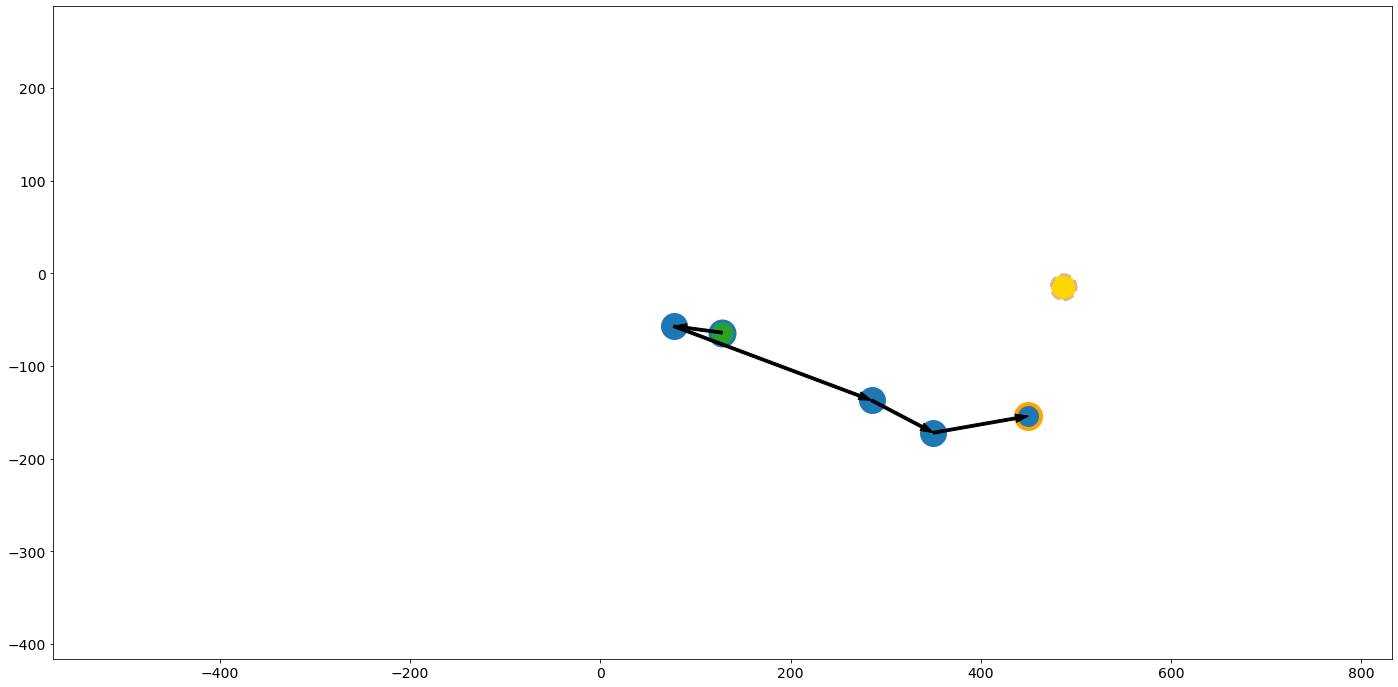

In [312]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)
ax = plt.gca()
plot_invis(env, ax)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)

plt.scatter(positions[exploration_path[:-1], 0], positions[exploration_path[:-1], 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(positions[exploration_path[-1:], 0], positions[exploration_path[-1:], 1], s=625, linewidths=4,
            color='tab:blue', edgecolor='orange', label='Frontier landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark', linestyle='--')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-transitions.png')

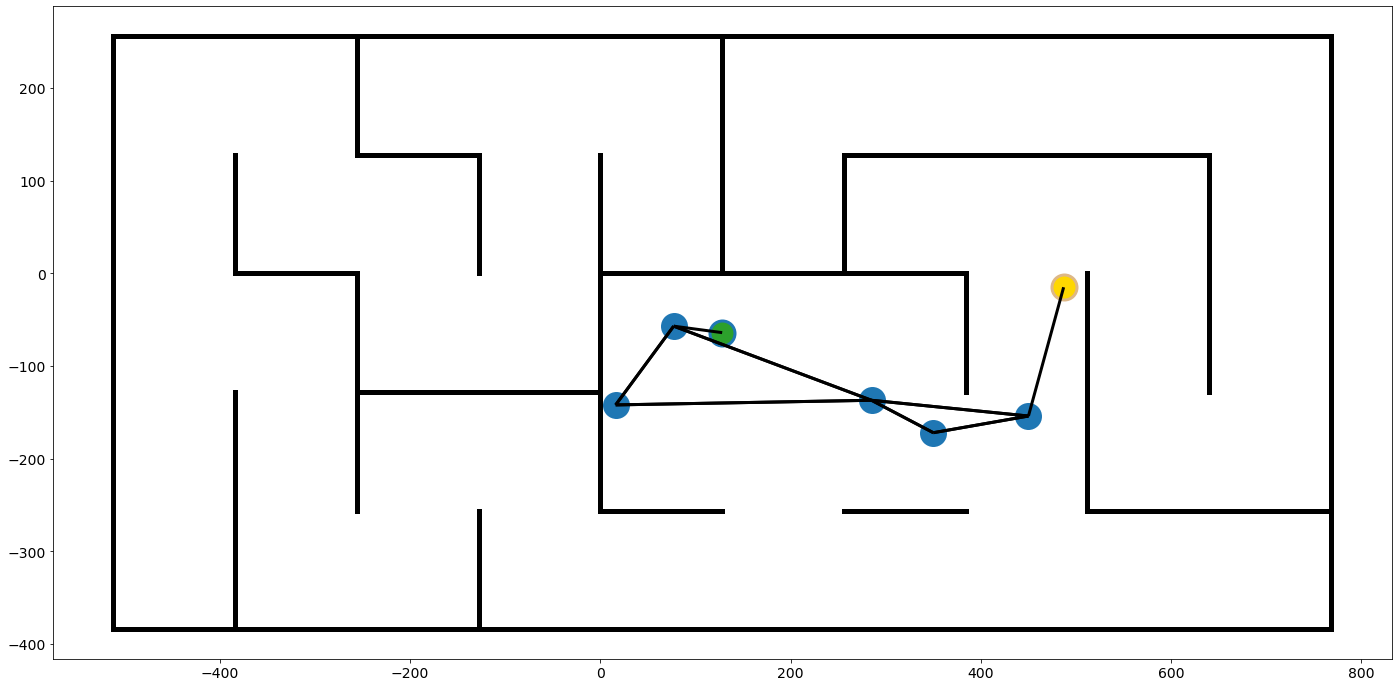

In [313]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=5)

ax = plt.gca()

starts = np.vstack([good_start[:2], positions[exploration_edges[:, 0], :2],
                    positions[exploration_path[-1], :2]])
ends = np.vstack([positions[exploration_path[0], :2], positions[exploration_edges[:, 1], :2],
                  positions[good_path[4], :2]])
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='black')
ax.add_collection(lc)

exploration_landmarks = np.unique(exploration_edges).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=625, linewidths=2,
            edgecolor='tab:blue', label='Landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-graph.png')

In [314]:
full_landmarks = np.unique(exploration_landmarks + good_path).tolist()
cross_full_landmarks = np.array(list(it.product(full_landmarks, full_landmarks)))
full_path_edges = np.zeros((N, N), dtype=bool)
full_path_edges[cross_full_landmarks[:, 0], cross_full_landmarks[:, 1]] = 1
full_path_edges = edge_weights.copy() * full_path_edges
full_path_edges = np.argwhere(full_path_edges > 0)

In [ ]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=5)

ax = plt.gca()

starts = positions[full_path_edges[:, 0], :2]
ends = positions[full_path_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='gray', linestyle='--')
ax.add_collection(lc)

full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)

lc = mc.LineCollection(lines,
                       linewidths=10, color='gold', alpha=0.5)
ax.add_collection(lc)
    
full_landmarks = np.unique(full_path_edges).tolist()

plt.scatter(positions[full_landmarks, 0], positions[full_landmarks, 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*good_goal[:2], marker='s', s=625, color='yellow', linewidths=3, edgecolor='black', label='Goal')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-evaluation.png')

In [495]:
graph = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)

In [504]:
goal_pairs['hardest'][1]

[[128, -64, 0], [-186.91343531517907, -54.017613909896774, 156.36838428897377]]

In [592]:
path_info = []

goal = [-450, 0, 0]
for start in [[0, -300, 90], [100, -300, 90]]:
    pair = [start, goal]
    path_info.append(get_path(pair, feature_model, dsr_model, graph))

SF start: 133
SF goal: 136
Found path: [133, 87, 68, 70, 63, 57, 23, 33, 31, 61, 91, 111, 110, 107, 108, 145, 121, 114, 123, 136]
SF start: 51
SF goal: 136
Found path: [51, 49, 39, 60, 36, 18, 9, 14, 65, 16, 66, 71, 80, 61, 91, 111, 110, 107, 108, 145, 121, 114, 123, 136]


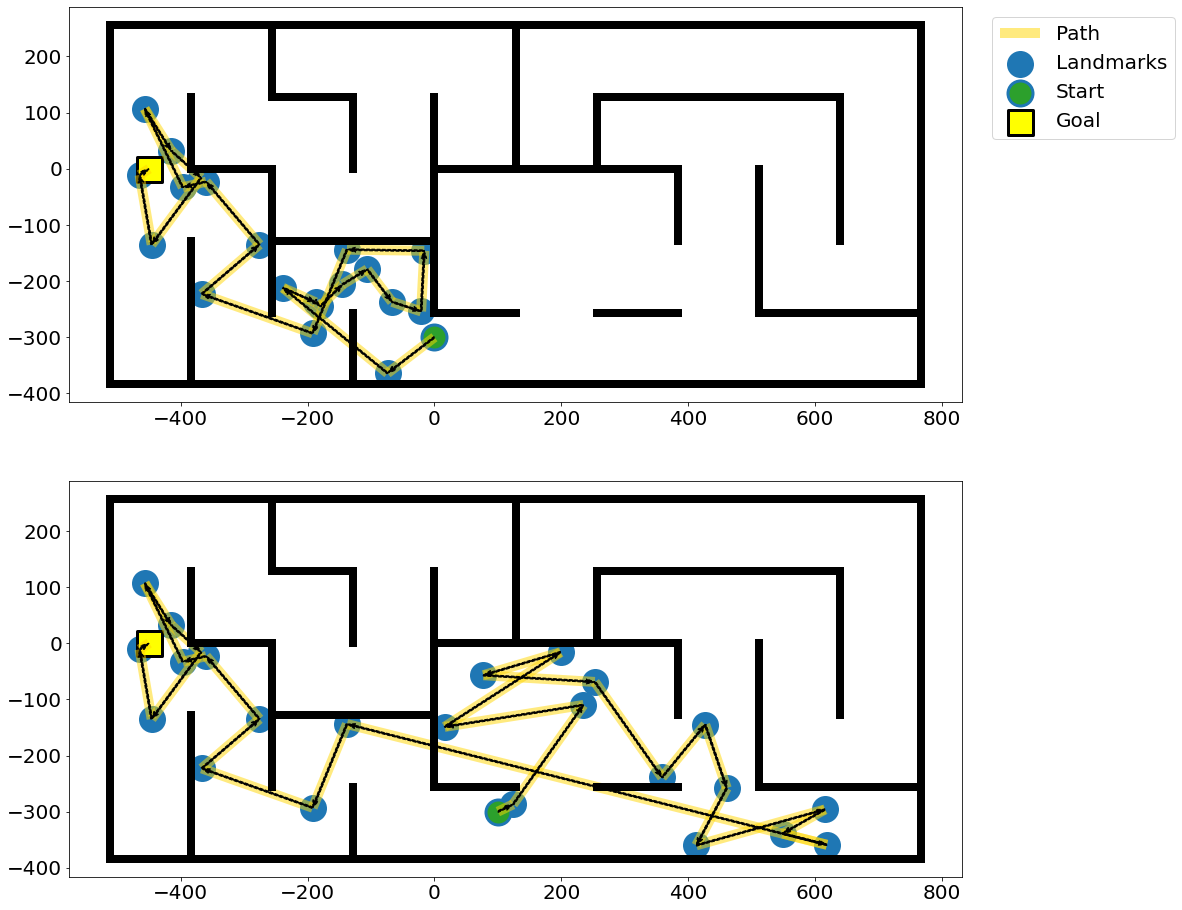

In [593]:
fig, axes = plt.subplots(2, 1, figsize=(16, 16))

for path, ax in zip(path_info, axes):
    good_start, good_goal, good_path = path
    plot_topdown(env, ax, linewidth=8)
    ax.tick_params(labelsize=20)

    full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
    full_path = list(map(tuple, full_path))
    lines = list(zip(full_path, full_path[1:]))

    for line in lines:
        x, y = line[0]
        dx = line[1][0] - x
        dy = line[1][1] - y
        ax.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10, linestyle='dashed')

    lc = mc.LineCollection(lines,
                           linewidths=10, color='gold', alpha=0.5, label='Path')
    ax.add_collection(lc)

    full_landmarks = np.unique(full_path_edges).tolist()

    ax.scatter(positions[good_path, 0], positions[good_path, 1], s=625, linewidths=2,
                color='tab:blue', edgecolor='tab:blue', label='Landmarks')
    ax.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
    ax.scatter(*good_goal[:2], marker='s', s=625, color='yellow', linewidths=3, edgecolor='black', label='Goal')
axes[0].legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.25, 1))
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/fixed-spawn-paths.png', bbox_inches='tight')

# SFS ViZDoom Heatmaps

1. sample points uniformly across map
2. for each point, move around until buffer is full
3. then compute SFS relative to start position

In [316]:
def get_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        features = features / torch.norm(features, p=2, dim=1, keepdim=True)
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        features = features.detach().cpu().numpy().squeeze()
        s_features = s_features.detach().cpu().numpy().squeeze()
    return features, s_features

In [317]:
def get_full_state(env, position, repeat=False):
    if repeat:
        return env.get_obs_at(position, idx=-1)
    env.get_obs_at(position)
    for _ in range(3):
        state, _, _, info = env.step(env.action_space.sample())
    return (state, info.position)

In [373]:
eval_dir = '../data/local/20201001/vizdoom/run_9/'
# eval_dir = '../data/visualize/run_8'

In [374]:
config = json.load(open(os.path.join(eval_dir, 'params.json')))
config['env']['config'] = '../' + config['env']['config']
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [375]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [467]:
env = VizDoomEnv(**config['env'])

In [377]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [383]:
env.reset()
start_state, start_pos = get_full_state(env, env.start_info[1], True)
start_f, start_sf = get_features(start_state, feature_model, dsr_model)

In [427]:
size_per_box = 10
num_samples_per_box = 1

In [428]:
x_starts = range(int(env.min_x), int(env.max_x), size_per_box)
y_starts = range(int(env.min_y), int(env.max_y), size_per_box)

In [429]:
print(len(list(it.product(x_starts, y_starts))))

8192


In [430]:
fs_data = defaultdict(list)
sfs_data = defaultdict(list)
i = 0
for x_start, y_start in it.product(x_starts, y_starts):
    for _ in range(num_samples_per_box):
        sample_x = np.random.uniform(x_start, x_start + size_per_box)
        sample_y = np.random.uniform(y_start, y_start + size_per_box)
        sample_theta = np.random.uniform(0, 360)
        sample_position = [sample_x, sample_y, sample_theta]
        sample_state, sample_pos = get_full_state(env, sample_position, True)
        sample_f, sample_sf = get_features(sample_state, feature_model, dsr_model)
        fs_data[(x_start, y_start)].append(np.dot(start_f, sample_f))
        sfs_data[(x_start, y_start)].append(np.dot(start_sf, sample_sf))
    i += 1
    if i > 500:
        print('RESET')
        env.reset()
        i = 0

RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET


In [431]:
with open('/mnt/brain1/scratch/choang/icml/figures/data/fs_data_{}_box{}.pkl'.format(num_samples_per_box, size_per_box), 'wb') as f:
    pickle.dump(fs_data, f, pickle.HIGHEST_PROTOCOL)

with open('/mnt/brain1/scratch/choang/icml/figures/data/sfs_data_{}_box{}.pkl'.format(num_samples_per_box, size_per_box), 'wb') as f:
    pickle.dump(sfs_data, f, pickle.HIGHEST_PROTOCOL)

In [447]:
clip = None

In [449]:
plot_fs_data = np.array(list(fs_data.keys())).astype('float')
plot_fs_data = np.insert(plot_fs_data, 2, list(map(np.mean, list(fs_data.values()))), axis=1)
if clip is not None:
    plot_fs_data[plot_fs_data[:, 2] < clip, 2] = 0

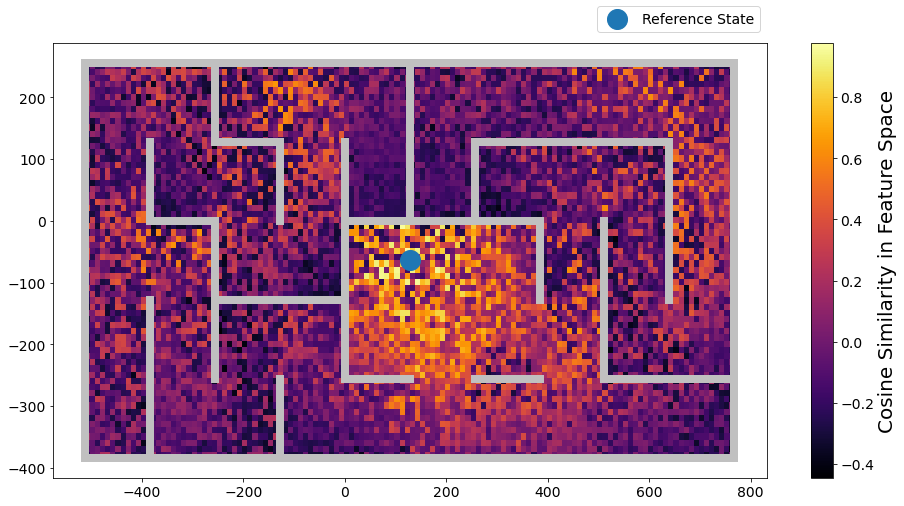

In [450]:
plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

plt.scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))

rects = []
for x, y in plot_fs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_fs_data[:, 2])
ax = plt.gca()
ax.add_collection(rects)
cbar = plt.colorbar(rects)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Cosine Similarity in Feature Space', fontsize=20)
if clip is not None:
    plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_clip{}_feature_similarity_{}_samples.png'.format(clip, num_samples_per_box))
else:
    plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_feature_similarity_{}_samples.png'.format(num_samples_per_box))

In [458]:
plot_sfs_data = np.array(list(sfs_data.keys())).astype('float')
plot_sfs_data = np.insert(plot_sfs_data, 2, list(map(np.mean, list(sfs_data.values()))), axis=1)
if clip is not None:
    plot_sfs_data[plot_sfs_data[:, 2] < clip, 2] = 0

In [ ]:
plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

plt.scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))

rects = []
for x, y in plot_sfs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_sfs_data[:, 2])
ax = plt.gca()
ax.add_collection(rects)
cbar = plt.colorbar(rects)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Successor Feature Similarity', fontsize=20)
if clip is not None:
    plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_clip{}_sfs_{}_samples.png'.format(clip, num_samples_per_box))
else:
    plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_sfs_{}_samples.png'.format(num_samples_per_box))

In [468]:
clipped_plot_sfs_data = plot_sfs_data.copy()
clipped_plot_sfs_data[clipped_plot_sfs_data[:, 2] <= 0.9, 2] = 0

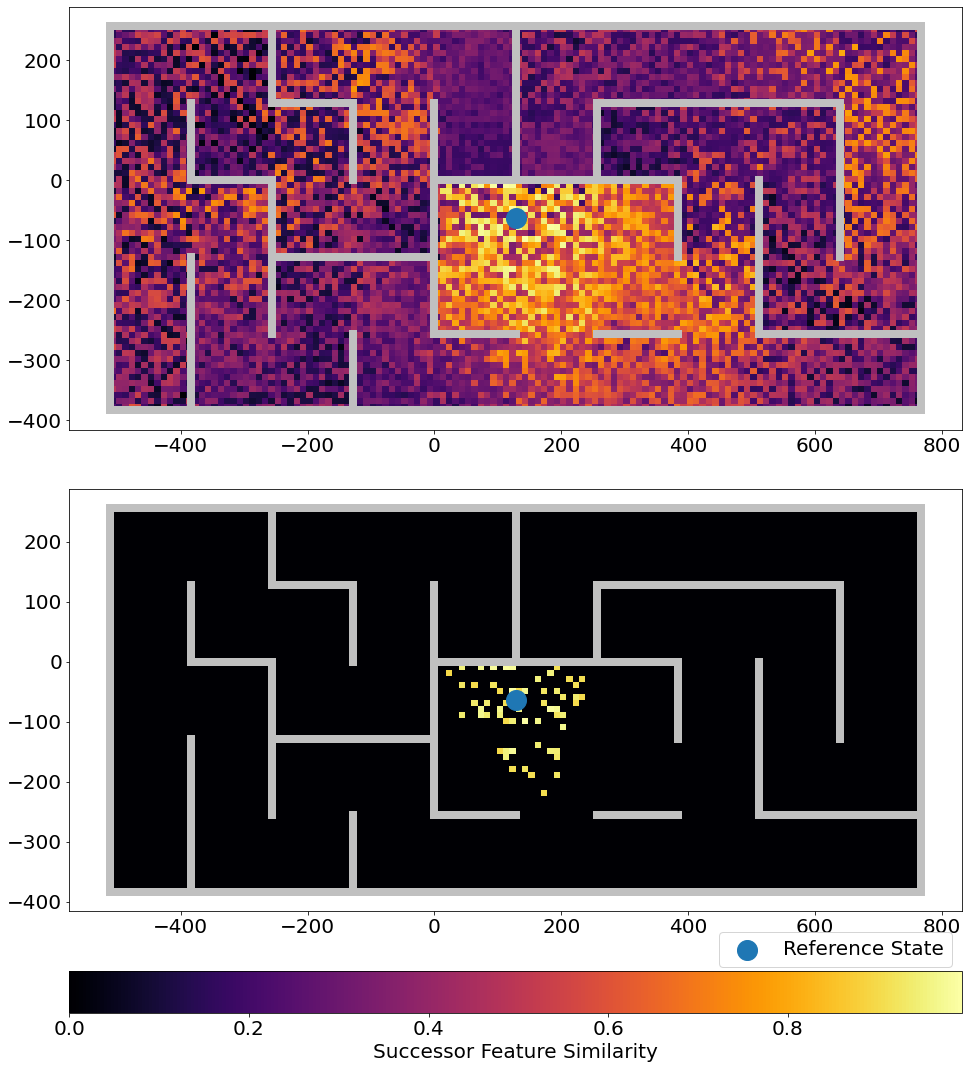

In [591]:
gridspec = {'height_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(3, 1, figsize=(16, 18.5), gridspec_kw=gridspec)
ax[0].tick_params(labelsize=20)
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax[0].plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax[0].scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')

rects = []
for x, y in plot_sfs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_sfs_data[:, 2])
ax[0].add_collection(rects)

ax[1].tick_params(labelsize=20)

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax[1].plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax[1].scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')

rects = []
for x, y in plot_sfs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(clipped_plot_sfs_data[:, 2])
ax[1].add_collection(rects)
ax[1].legend(loc='upper right', fontsize=20, bbox_to_anchor=(1, -0.025))
cbar = fig.colorbar(rects, cax = ax[2], orientation='horizontal', pad=0.180)
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('Successor Feature Similarity', fontsize=20)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/sfs-heatmap-comparison.png')

## Old

In [3]:
with open('../experiments/configs/small-eval-settings.json') as f:
    small_goals = json.load(f)

In [4]:
with open('../experiments/configs/memory-small-full.json') as f:
    small_config = json.load(f)
small_config['env']['config'] = '../' + small_config['env']['config']

In [5]:
with open('../experiments/configs/memory-train-full.json') as f:
    train_config = json.load(f)
train_config['env']['config'] = '../' + train_config['env']['config']

In [102]:
small_env = VizDoomEnv(**small_config['env'])
train_env = VizDoomEnv(**train_config['env'])

In [103]:
levels = ['easy', 'medium', 'hard', 'hardest']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

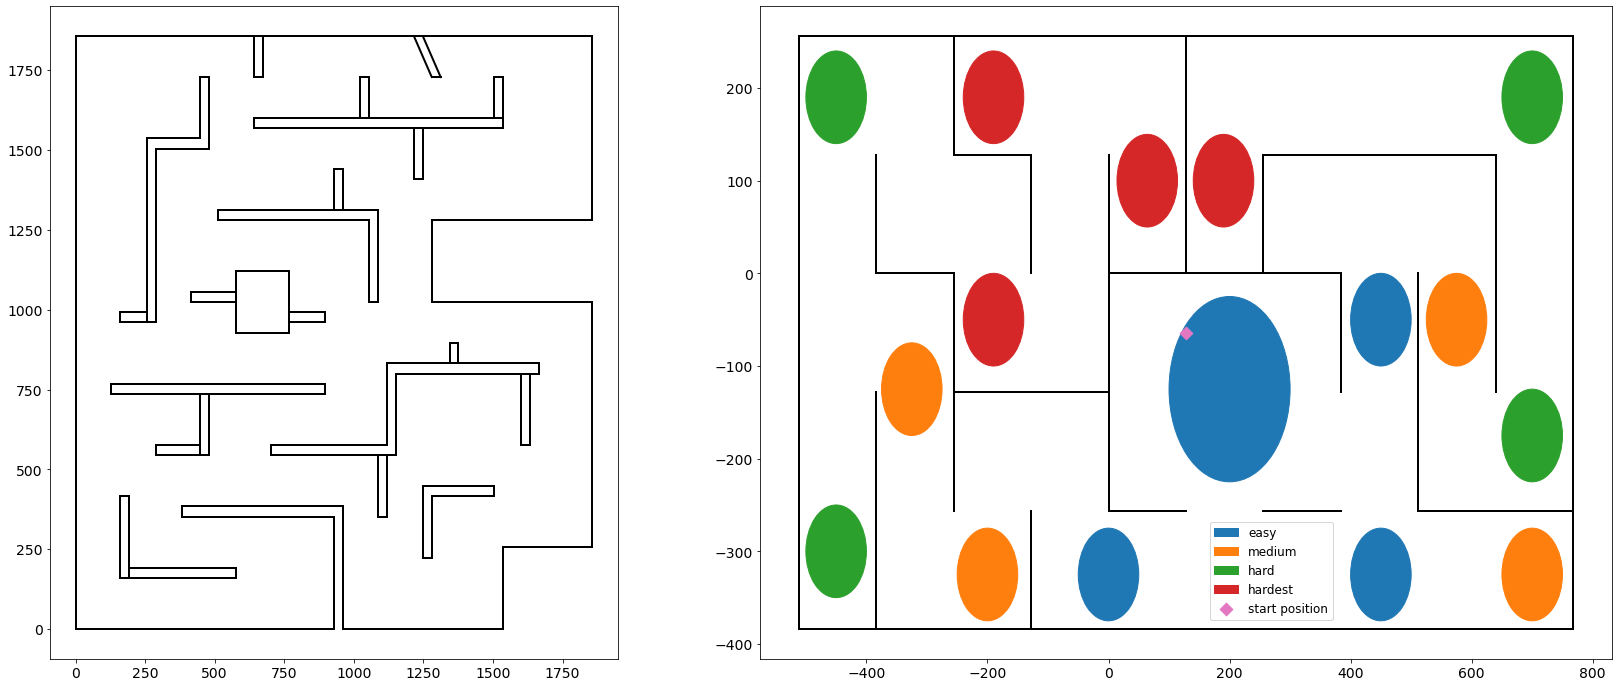

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12), gridspec_kw={'width_ratios': [1, 1.5]})
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plot_topdown(train_env, ax1)
plot_topdown(small_env, ax2)
circles = []
for level, color in zip(levels, colors):
    goal_areas = small_goals[level]
    for goal_area in goal_areas:
        x, y, r = goal_area
        circle = plt.Circle((x, y), r, color=color, label=level, zorder=-1)
        ax2.add_artist(circle)
    circles.append(circle)
agent = ax2.scatter(*small_config['env']['start_position'][:2], s=81, color='tab:pink', marker='D', label='start position', zorder=1)
ax2.legend(handles=[*circles, agent], loc='lower center', bbox_to_anchor=(0.60, 0.05), fontsize=12)
plt.savefig('images/mazes.png', bbox_inches='tight')

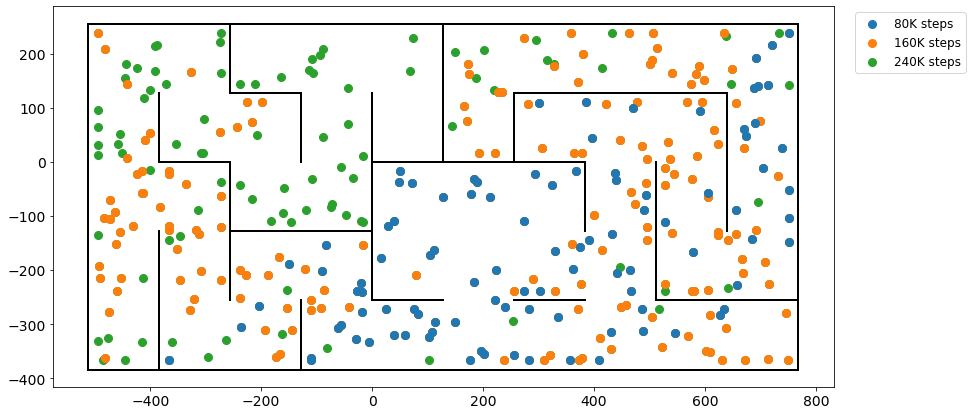

In [547]:
# plt.figure(figsize=(14, 7))

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_9999.npz')
# positions = landmarks['positions']
# plot_topdown(small_env, plt)
# plt.scatter(positions[:, 0], positions[:, 1], label='80K steps', s=64, zorder=3)

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_19999.npz')
# positions = landmarks['positions']
# plt.scatter(positions[:, 0], positions[:, 1], label='160K steps', s=64, zorder=2)

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_29999.npz')
# positions = landmarks['positions']
# plt.scatter(positions[:, 0], positions[:, 1], label='240K steps', s=64, zorder=1)

# plt.tick_params(labelsize=14)
# plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1))
# plt.savefig('images/landmark_expansion.png', bbox_inches='tight')

In [198]:
small_config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    small_config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [449]:
feature_model = FixedVizDoomModel(**small_config['agent']['feature_model_kwargs'])
feature_model.to(device)

FixedVizDoomModel(
  (encoder): Linear(in_features=1, out_features=1, bias=True)
)

In [548]:
weights = torch.load('../data/local/20200922/vizdoom/run_0/itr_249999.pkl', map_location=device)
landmarks = np.load('../data/local/20200922/vizdoom/run_0/landmarks_itr_249999.npz')

In [549]:
dsr_model = DsrModel(train_env.observation_space.shape,
                     train_env.action_space.n, **train_config['agent']['model_kwargs']).to(device)

In [550]:
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [551]:
def get_s_features(state, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

In [552]:
positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [554]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])

true_edges = random_transitions >= threshold
# true_edges = temporally_nearby_landmarks & true_edges

k = 5
nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
k_filter = np.zeros((N, N), dtype=bool)
idx = np.vstack([np.arange(N)] * k).T
k_filter[idx, nearest_neighbors] = True
true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

edges = np.argwhere(edge_weights > 0)
print('Number of edges:', edges.shape[0])

Number of landmarks: 2433
Number of non-zero random transitions: 41219
50 percentile of random transitions: 1.0
Number of subgoal edges: 8456
Number of failure edges: 2552
Number of edges: 10121


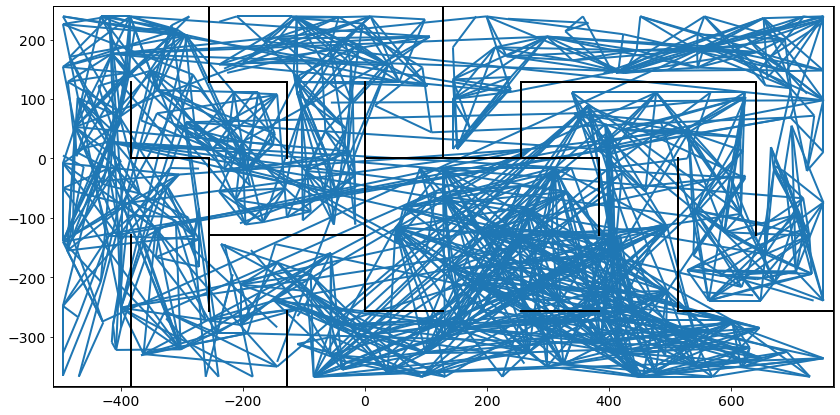

In [542]:
starts = positions[edges[:, 0], :2]
ends = positions[edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=2)
fig, ax = plt.subplots(figsize=(14, 7))
plt.tick_params(labelsize=14)
ax.set_xlim(small_env.min_x, small_env.max_x)
ax.set_ylim(small_env.min_y, small_env.max_y)
plot_topdown(small_env, ax)
ax.add_collection(lc)
plt.savefig('images/edges-failures-temporal-landmarks.png')

In [556]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

with open('../experiments/configs/225-train-random-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [557]:
env = train_env

In [611]:
def get_path(goal_idx):
    start_pos, goal_pos = goal_pairs['easy'][goal_idx]
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state)
    goal_sf = get_s_features(goal_state)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [617]:
good_start, good_goal, good_path = get_path(11)
bad_start, bad_goal, bad_path = get_path(5)

SF start: 422
SF goal: 1400
Found path: [422, 380, 397, 466, 385, 368, 375, 389, 394, 1400]
SF start: 111
SF goal: 921
Found path: [111, 124, 31, 39, 1287, 717, 1375, 715, 598, 596, 778, 688, 675, 776, 503, 500, 643, 637, 491, 594, 375, 1352, 365, 377, 5, 216, 103, 1978, 970, 971, 6, 299, 963, 914, 339, 918, 921]


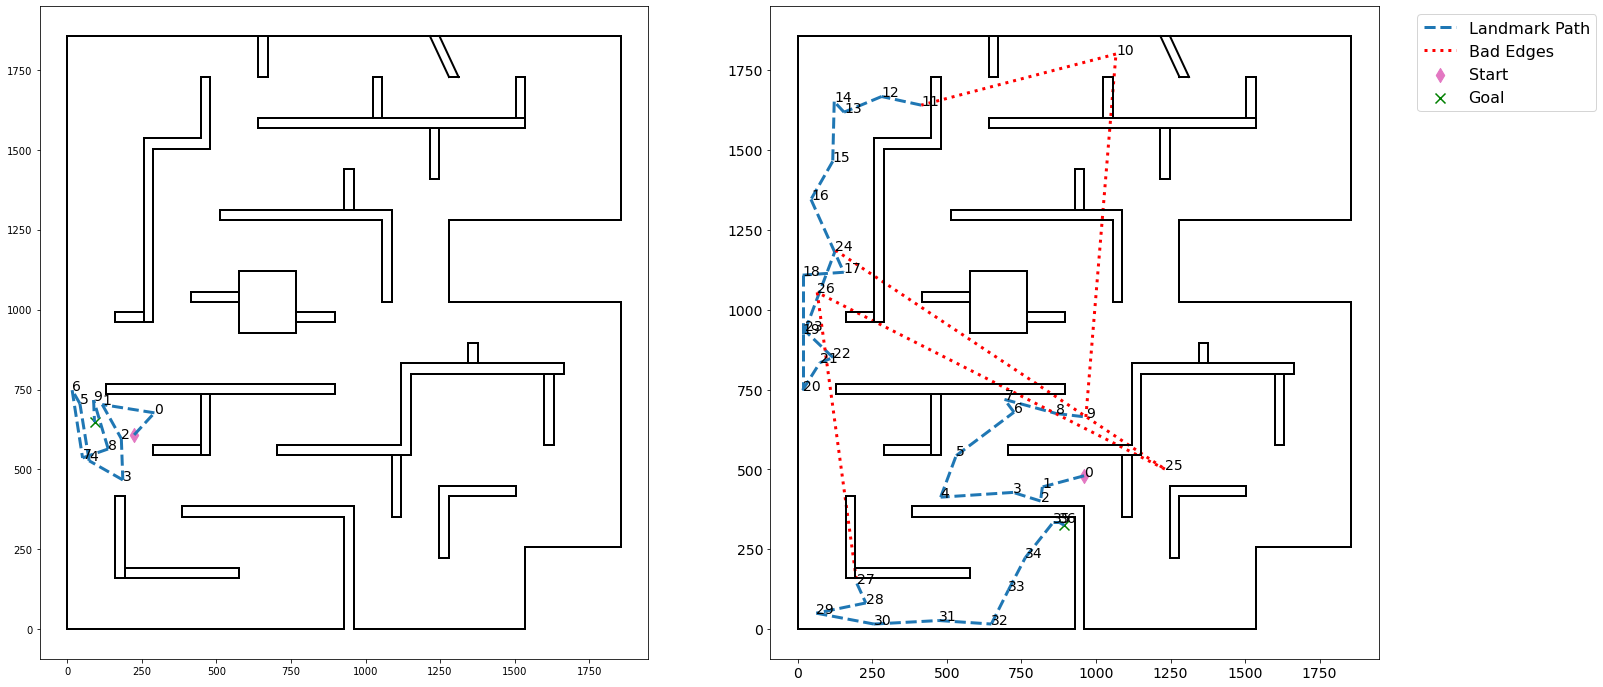

In [625]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
plot_topdown(env, ax1)
for i, landmark in enumerate(good_path):
     ax1.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))


lc = mc.LineCollection(lines, linewidths=3, linestyle='--', label='Landmark Path')
ax1.add_collection(lc)

ax1.scatter(*good_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax1.scatter(*good_goal[:2], marker='x', s=100, color='green', label='Goal')

plot_topdown(env, ax2)
for i, landmark in enumerate(bad_path):
     ax2.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [bad_start[:2], *positions[bad_path, :2], bad_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

bad_lines = [10, 11, 25, 26, 27]
lc = mc.LineCollection([lines[i] for i in range(len(lines)) if i not in bad_lines], 
                       linewidths=3, linestyle='--', label='Landmark Path')
ax2.add_collection(lc)
lc = mc.LineCollection([lines[i] for i in bad_lines], 
                       linewidths=3, linestyle=':', color='red', label='Bad Edges')
ax2.add_collection(lc)

ax2.scatter(*bad_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax2.scatter(*bad_goal[:2], marker='x', s=100, color='green', label='Goal')

plt.tick_params(labelsize=14)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
plt.savefig('images/random-paths.png', bbox_inches='tight')